

![JohnSnowLabs](https://nlp.johnsnowlabs.com/assets/images/logo.png)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://githubtocolab.com/JohnSnowLabs/spark-nlp-workshop/blob/master/tutorials/streamlit_notebooks/NER.ipynb)




# **Detect entities in different languages**

### Spark NLP documentation and instructions:
https://nlp.johnsnowlabs.com/docs/en/quickstart

### You can find details about Spark NLP annotators here:
https://nlp.johnsnowlabs.com/docs/en/annotators

### You can find details about Spark NLP models here:
https://nlp.johnsnowlabs.com/models


## 1. Colab Setup

In [ ]:
# Install PySpark and Spark NLP
! pip install -q pyspark==3.3.0 spark-nlp==4.2.8

# Install Spark NLP Display lib
! pip install --upgrade -q spark-nlp-display

## 2. Start the Spark session

Import dependencies and start Spark session.

In [2]:
import json
import pandas as pd
import numpy as np

import sparknlp
import pyspark.sql.functions as F

from pyspark.ml import Pipeline
from pyspark.sql import SparkSession
from sparknlp.annotator import *
from sparknlp.base import *
from sparknlp.pretrained import PretrainedPipeline
from pyspark.sql.types import StringType, IntegerType

In [3]:
spark = sparknlp.start()

print("Spark NLP version", sparknlp.version())
print("Apache Spark version:", spark.version)

spark

Spark NLP version 4.2.8
Apache Spark version: 3.3.0


## 3. Select the DL model & Supported Embeddings

### 3.1 Select the correct NER model for your use case:



For complete model list: 
https://nlp.johnsnowlabs.com/models

For `NER` models:
https://nlp.johnsnowlabs.com/models?tag=ner

### 3.2 Select the correct embeddings supported by the chosen model.

**Embeddings can be identified in a number of ways:**

**1. Embeddings required for each NER model is specified either in the description**

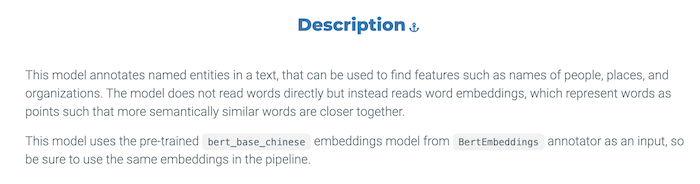


**OR**

**2. In the Model Information table**


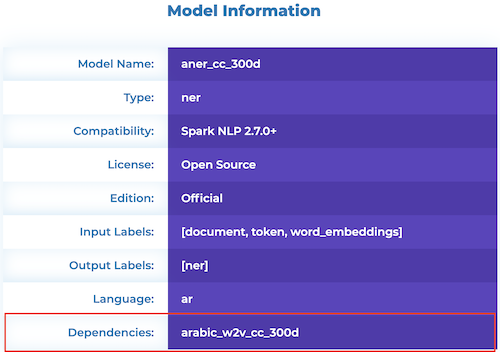

**OR**


**3. The model name - models names are informative and give an idea of the embeddings used to train them, like `onto_bert_base_cased` to indicate bert embeddings were used, similarly, `aner_cc_300d` to indicate word embedding of 300d was used of that specific langauge**

**NOTE: Typically small models (models having _sm at the end of their name) use glove_100d, medium models use glove_6B_300 and large models use glove_840B_300 embeddings**

## 4. A sample text in Danish for demo

In [4]:
text_list = ["""Mona Lisa er et oliemaleri fra det 16. århundrede skabt af Leonardo. Det afholdes på Louvre i Paris."""]

## 5. Define Spark NLP pipeline

In [5]:
documentAssembler = DocumentAssembler() \
    .setInputCol('text') \
    .setOutputCol('document')

sentence_detector = SentenceDetector() \
    .setInputCols('document') \
    .setOutputCol('sentence')


tokenizer = Tokenizer() \
    .setInputCols(['sentence']) \
    .setOutputCol('token')

'''
Note:

For embeddings that offer multi-language support like glove_6B_300, we use 'xx'
in the language parameter.

e.g: embeddings = WordEmbeddingsModel.pretrained('glove_6B_300', lang='xx') \
        .setInputCols(["sentence", 'token']) \
        .setOutputCol("embeddings")

For dedicated embeddings like 'aner_cc_300d' the language parameter would be 
the corresponding language.

e.g: embeddings = WordEmbeddingsModel.pretrained('aner_cc_300d', lang='ar') \
        .setInputCols(["sentence", 'token']) \
        .setOutputCol("embeddings")

'''
## to use Glove embeddings
embeddings = WordEmbeddingsModel.pretrained('glove_6B_300', lang='xx') \
        .setInputCols(["sentence", 'token']) \
        .setOutputCol("embeddings")

## to use Bert Embeddings
#embeddings = BertEmbeddings.pretrained(name='bert_base_cased', lang='en') \
#        .setInputCols(['document', 'token']) \
#        .setOutputCol('embeddings')

# select your desired model and define language
ner_model = NerDLModel.pretrained('dane_ner_6B_300', lang='da') \
    .setInputCols(['sentence', 'token', 'embeddings']) \
    .setOutputCol('ner')

ner_converter = NerConverter() \
    .setInputCols(['sentence', 'token', 'ner']) \
    .setOutputCol('ner_chunk')

nlp_pipeline = Pipeline(
    stages=[
        documentAssembler, 
        sentence_detector,
        tokenizer,
        embeddings,
        ner_model,
        ner_converter])

glove_6B_300 download started this may take some time.
Approximate size to download 426.2 MB
[OK!]
dane_ner_6B_300 download started this may take some time.
Approximate size to download 14.2 MB
[OK!]


## 6. Run the pipeline

In [6]:
df = spark.createDataFrame(text_list, StringType()).toDF("text")
result = nlp_pipeline.fit(df).transform(df)

## 7. Visualize results

In [7]:
from sparknlp_display import NerVisualizer

NerVisualizer().display(
    result = result.collect()[0],
    label_col = 'ner_chunk',
    document_col = 'document'
)